# Class Activation Mapping (CAM) on MNIST

The class activation mapping (CAM) method produces a saliency map from any convolutional layer of the image classification model. We use cam on the final convolutional layer as it provides the best results. Unlike the gradient methods, CAM places strict requirements on the models. CAM's requirements are listed below: 
- The classification model needs to have convolutional layers.
- The model mustn't have fully connected layers (dense layers).
- It requires a global average pooling (GAP) layer as the last layer before the softmax layer.

Unfortunately replacing the fully connected layers with a GAP layer makes training very slow. I worked around this issue by using the fully connected layers during training. Then when extracting the saliency map I will access the intermediate convolutional layer using Flax's sow method. Then GAP is added to the convolutional layer. This ensures fast training time while satisfying all CAM's requirements.  

For more technical information on the class activation mapping method see: [Learning Deep Features for Discriminative Localization](https://arxiv.org/abs/1512.04150)


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import jax.numpy as jnp
import flax.linen as nn
import jax
from jax import random
from jax import grad
from keras.utils import data_utils

2022-11-06 15:36:14.904708: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-06 15:36:15.592566: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2022-11-06 15:36:15.592672: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.6/lib64:
2022-11-06 15:36:15.592679: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned a

### Load training data
Check if the training data exists. If not, automatically download it.

In [2]:
data_dir = os.path.abspath("./digit-recognizer")
os.makedirs(data_dir, exist_ok=True)
train_data_path = f"{data_dir}/train.zip"
train_data_url = "https://huggingface.co/datasets/ChristianOrr/mnist/resolve/main/train.zip"

if not os.path.exists(train_data_path):
    print("Downloading training data...")
    data_utils.get_file(
        train_data_path, 
        train_data_url, 
        extract=True, 
        cache_dir=data_dir
        )

data_df = pd.read_csv('./digit-recognizer/datasets/train.csv')

In [3]:
val_size = 1000
# Only shuffle training data
np.random.shuffle(data_df[val_size:].values)
m, n = data_df.shape
Y = jnp.array(data_df["label"])
data_df = data_df.drop("label", axis=1)
X = jnp.array(data_df)


X_train = X[val_size:]
X_train = X_train / 255.
Y_train = Y[val_size:]

X_val = X[:val_size]
X_val = X_val / 255.
Y_val = Y[:val_size]

### Define the classification model

In [4]:
class _forward_fn(nn.Module):

    @nn.compact
    def __call__(self, x):
        batch_size = x.shape[0]
        # Unflatten for the convolution layers
        x = x.reshape(batch_size, 28, 28, 1)
        mlp = nn.Sequential([
            nn.Conv(features=16, kernel_size=(3, 3), padding="VALID", use_bias=False), jax.nn.relu,
            nn.Conv(features=32, kernel_size=(3, 3), padding="VALID", use_bias=False), jax.nn.relu,
            nn.Conv(features=10, kernel_size=(3, 3), padding="VALID", use_bias=False), jax.nn.relu,    
        ])
        x = mlp(x)
        # Save the final convolution layer as an intermediate so 
        # it can be accessed for the cam algorithm
        self.sow("intermediates", "final_conv_layer", x)

        x = x.reshape((batch_size, -1))
        x = nn.Dense(10)(x)
        return jax.nn.softmax(x)

# Create the model object
forward_fn = _forward_fn()
# Display the model details
dummy_x = X_train[:5]
rng_key = random.PRNGKey(64)
initial_params = forward_fn.init(rng_key, dummy_x)
print(forward_fn.tabulate(rng_key, dummy_x))


                              _forward_fn Summary                               
┏━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ path       ┃ module     ┃ inputs     ┃ outputs    ┃ intermedia… ┃ params     ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│            │ _forward_… │ float32[5… │ float32[5… │ final_conv… │            │
│            │            │            │            │ -           │            │
│            │            │            │            │ float32[5,… │            │
│            │            │            │            │             │            │
│            │            │            │            │ 24,200      │            │
│            │            │            │            │ (96.8 KB)   │            │
├────────────┼────────────┼────────────┼────────────┼─────────────┼────────────┤
│ Sequentia… │ Sequential │ float32[5… │ float32[5… │             │            │
├────────────┼────────────┼

### Define the loss function and update method

In [5]:
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[..., None] == jnp.arange(k), dtype)

def loss_fn(params, X, Y):
    logits = forward_fn.apply(params, X)
    one_hot_Y = one_hot(Y, 10)
    loss = -jnp.sum(one_hot_Y * jnp.log(logits)) / m
    return loss


def update_rule(param, update):
    return param - 0.1 * update

def update_params(params, alpha, X, Y):
    grads = grad(loss_fn, argnums=0)(params, X, Y)
    params = jax.tree_util.tree_map(update_rule, params, grads)
    return params


### Train the model

In [6]:
def get_predictions(logits):
    return jnp.argmax(logits, axis=1)

def get_accuracy(predictions, Y):
    return jnp.mean(predictions == Y)

def gradient_descent(X, Y, batch_size, alpha, epochs):
    dataset_size = len(X)
    steps_per_epoch = dataset_size // batch_size

    rng = jax.random.PRNGKey(42)
    params = forward_fn.init(rng, X[0: batch_size, :])

    for epoch in range(epochs):
        dataset_step = epoch % steps_per_epoch
        dataset_index = dataset_step * batch_size
        input = X[dataset_index: dataset_index + batch_size, :]
        label = Y[dataset_index: dataset_index + batch_size, ...]
        params = update_params(params, alpha, input, label)
        if epoch % 10 == 0:
            print("Iteration: ", epoch)
            logits = forward_fn.apply(params, input)
            predictions = get_predictions(logits)
            print(get_accuracy(predictions, label))
    return params

In [7]:
params = gradient_descent(X_train, Y_train, 2000, 0.10, 200)

2022-11-06 15:36:43.004526: W external/org_tensorflow/tensorflow/tsl/framework/bfc_allocator.cc:290] Allocator (GPU_0_bfc) ran out of memory trying to allocate 1.47GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


Iteration:  0
0.119
Iteration:  10
0.31800002
Iteration:  20
0.54950005
Iteration:  30
0.7195
Iteration:  40
0.77650005
Iteration:  50
0.81750005
Iteration:  60
0.84250003
Iteration:  70
0.8485
Iteration:  80
0.8615
Iteration:  90
0.86500007
Iteration:  100
0.86500007
Iteration:  110
0.8705
Iteration:  120
0.87100005
Iteration:  130
0.8705
Iteration:  140
0.86600006
Iteration:  150
0.86950004
Iteration:  160
0.86200005
Iteration:  170
0.874
Iteration:  180
0.87450004
Iteration:  190
0.87850004


### Display predictions and saliency maps

CAM can be performed on any of the convolutional layers. For this demonstration we use the final convolutional layer. To access the convolutional layer it needs to be stored as an intermediate variable in the model definition, then the "mutable='intermediates'" argument is supplied to the model when performing the forward pass. Global average pooling is then applied to the convolutional layer. This is performed by taking the mean of each filter/feature map, this results in a vector of floats with the size of the number of feature maps. The vector is then used as weights for the feature maps. The dot product is taken between the weights and feature maps to provide us with the class activation mapping. 

In [8]:
def make_predictions(X, params):
    logits, state = forward_fn.apply(params, X, mutable='intermediates')
    predictions = get_predictions(logits)
    return predictions, state

def prep_image(image):
    # Normalize the gradient values to be between 0-1
    max_val= np.max(image)
    min_val = np.min(image)
    image = (image - min_val) / (max_val - min_val)
    # Convert the grads to uint8 for displaying
    image = np.uint8(image * 255)
    return image   

def display_prediction(index, params):
    current_image = X_val[None, index]
    prediction, state = make_predictions(X_val[None, index], params)

    label = Y_val[index]
    print("Prediction: ", prediction)
    print("Label: ", label)

    display_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(display_image, interpolation='nearest')
    plt.axis('off')
    plt.title("Input Image")
    plt.show()

    
    final_conv_layer = state["intermediates"]["final_conv_layer"][0][0]
    # Get weights using global average pooling
    weights = jnp.mean(final_conv_layer, axis=(0, 1))
    # Get the weighted sum of all the filters
    cam = jnp.dot(final_conv_layer, weights)
    cam = prep_image(cam)

    plt.gray()
    plt.imshow(cam, interpolation='nearest')
    plt.axis('off')
    plt.title("Saliency Map")
    plt.show()

Prediction:  [1]
Label:  1


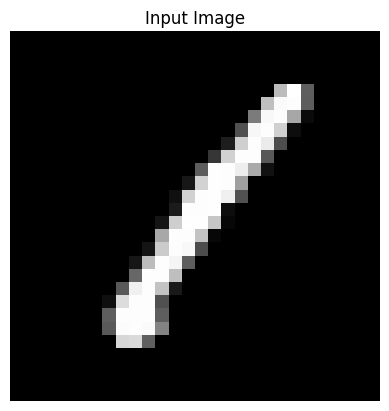

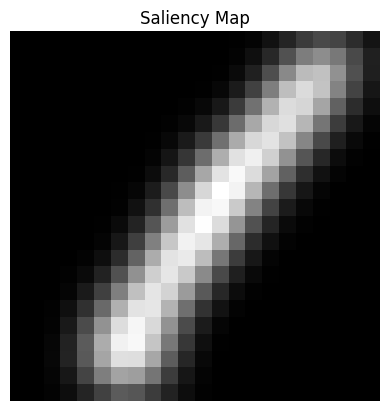

Prediction:  [2]
Label:  4


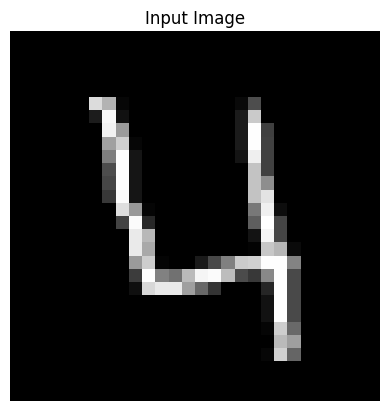

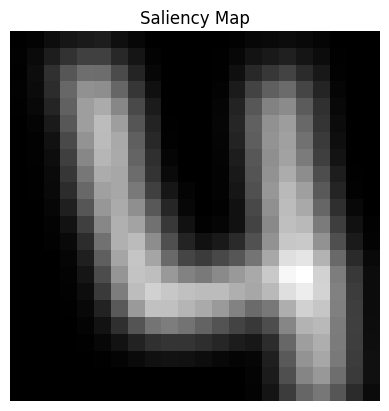

Prediction:  [0]
Label:  0


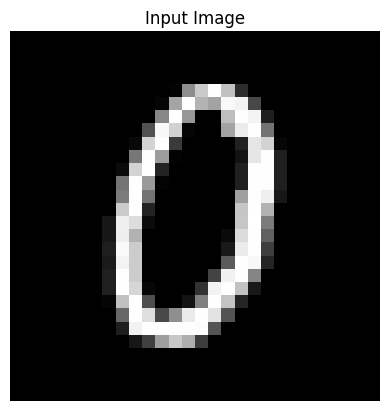

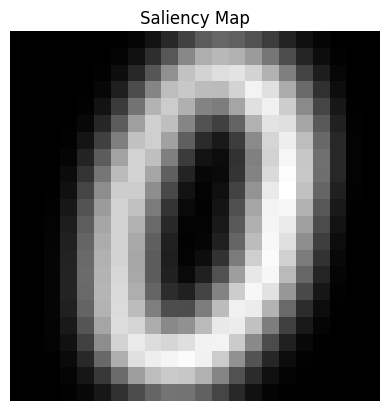

Prediction:  [5]
Label:  5


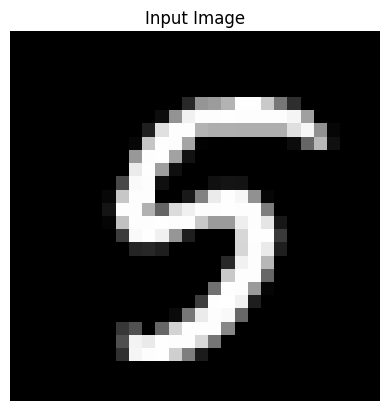

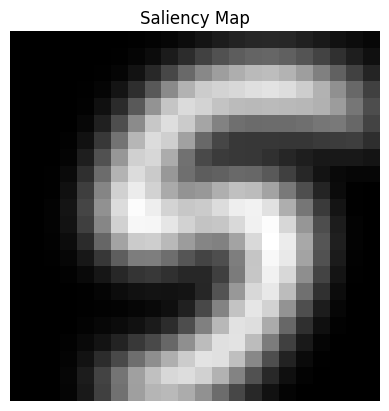

Prediction:  [8]
Label:  8


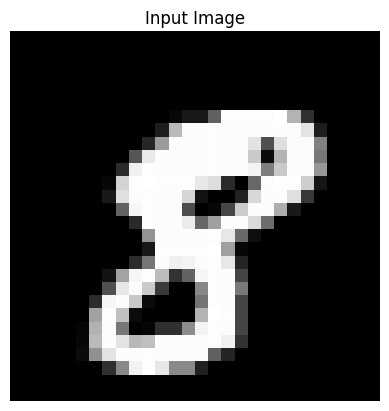

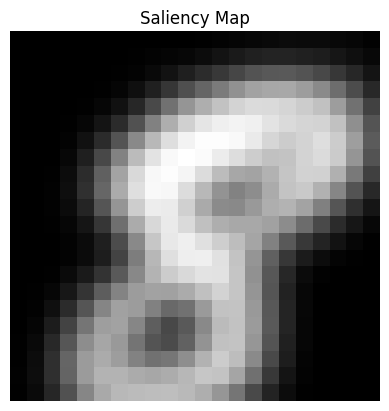

Prediction:  [7]
Label:  7


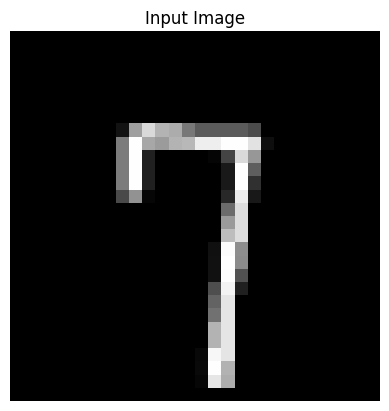

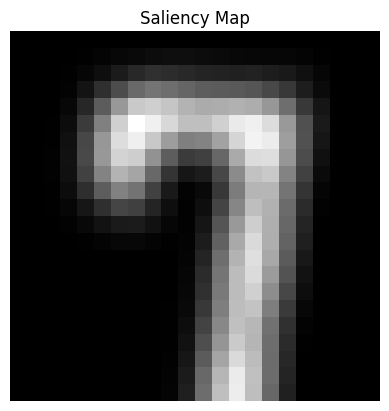

In [9]:
display_prediction(0, params)
display_prediction(3, params)
display_prediction(5, params)
display_prediction(8, params)
display_prediction(10, params)
display_prediction(50, params)